In [1]:
#imports
import os
import sys
import copy
# os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ['TMPDIR'] = '/dat1/smart1n/tmp'

sys.path.append('/dat1/smart1n/OpenSTL/openstl')

from models.simvp_model import SimVP_Model_no_skip
import numpy as np
# from src.models import *
from pytorch_losses import *
import torch
from torch import optim
# import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt

import csv
# from apex.optimizers import FusedAdam

In [ ]:
n_t = 30
L_x = 960e3
L_y = 960e3
n=128
batch_size = 25 # DON'T CHANGE, THIS IS FIXED IN THE PRE-PROCESSING TO BE 1 BATCH PER FILE
n_train_batches = 1000
n_train=n_train_batches
n_val=1000
n_val_batches = n_val
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Specify the GPU device

batch_size=25
n_t = 30
region = 'gulf stream' # 'global' or 'gulf stream'
mode = 'SLA' # 'SLA-SST' or 'SST'

#FILL IN: THESE ARE THE DIRECTORIES FOR THE DATA AND THE ASSOCIATED STATISTICS 
datadir = '/home/jovyan/prepro-new/'
mean_ssh =np.load("../../deep-learning-ssh-mapping-JAMES-paper/gs_mean_ssh_future.npy")
std_ssh=np.load("../../deep-learning-ssh-mapping-JAMES-paper/gs_std_ssh_future.npy")
mean_sst=np.load("../../deep-learning-ssh-mapping-JAMES-paper/gs_mean_sst_future.npy")
std_sst=np.load("../../deep-learning-ssh-mapping-JAMES-paper/gs_std_sst_future.npy")
stats = (mean_ssh, std_ssh, mean_sst, std_sst)

#Parameters for training and validation
params = {'dim': (n_t,128,128),
          'batch_size': batch_size,
          'n_channels': 1,
          'shuffle': True,
          'val':'training/',
          'datadir':datadir,
         'stats':stats}
params_val = {'dim': (n_t,128,128),
          'batch_size': batch_size,
          'n_channels': 1,
          'shuffle': False,
              'val':'validation/',
          'datadir':datadir,
             'stats':stats}


#FILL IN: Directory to weights and hyperparameters, as well as experiment name
weight_dir ='/home/jovyan/OpenSTL/openstl/weights/'
l2,dropout,droppath=tuple(np.load('newregionbest_hyperparameters.npy'))
hyper_params=[l2,dropout,droppath]
experiment_name = f'simvp_sla_no_grads_ntrain{n_train}k_smoothing_future_l2_'+str(l2)+'_dropout'+str(dropout)+'_droppath_'+str(droppath)


#Data gen
class SSH_Dataset(Dataset):
    def __init__(self, list_IDs,mode,batch_size=25,dim=(6,128,128), n_channels=1, shuffle=True, val = 'training', datadir = '30 days 1920km 128x128/training_processed/', stats = (0,1,0,1)):
        self.mode=mode
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.val = val
        self.datadir = datadir
        self.stats = stats
    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, idx):
        mean_ssh, std_ssh, mean_sst, std_sst = self.stats
        
        # Initialization
        
        X1 = np.empty((self.batch_size, self.dim[0], 128, 128, 1))
        X2 = np.empty((self.batch_size, self.dim[0], 128, 128, 1))

        # X2 = np.empty((self.batch_size, self.dim[0], 128, 128, 1))
        # X3 = np.empty((self.batch_size, 30, 128, 128, 1))
        # Y = np.empty((self.batch_size, *self.dim, 1))
        Y_length = []
        Y_list = []
        mode=self.mode
        if mode=="SLA-SST":
            ID=self.list_IDs[idx] #ID
            
            input_ = np.load(self.datadir + self.val +'batch' + ID + "_invar.npy")
            ssh = copy.deepcopy(input_[:,:,:,:,0])
            ssh[np.isnan(ssh)] = 0
            ssh[ssh!=0] = (ssh[ssh!=0]-mean_ssh)/std_ssh

            sst = copy.deepcopy(input_[:,:,:,:,1])
            sst[np.isnan(sst)] = 0

            sst[sst<273]=0
            sst[sst!=0] = (sst[sst!=0]-mean_sst)/std_sst


            X1[:,:,:,:,0] = ssh[:,:self.dim[0],:,:]
            X2[:,:,:,:,0] = sst[:,:self.dim[0],:,:]

            ssh_out = np.load(self.datadir + self.val +'batch' + ID + "_outvar.npy")

            ssh_out = ssh_out[:self.dim[0],]

            ssh_out[np.isnan(ssh_out)] = 0
            x = copy.deepcopy(ssh_out[:,:,:,0])
            x[x!=0] = ((x[x!=0]+0.5*960e3)/960e3)*(128-1)
            y = copy.deepcopy(ssh_out[:,:,:,1])
            #OUTPUT DIMENSIONS: sample, day, maximum number of satellites, x y and SSH

            y[y!=0] = ((-y[y!=0]+0.5*960e3)/960e3)*(128-1)
            sla = copy.deepcopy(ssh_out[:,:,:,2])
            sla[sla!=0] = (sla[sla!=0]-mean_ssh)/std_ssh
            outvar = np.stack((x,y,sla),axis = -1)
            Y=outvar

            X = [X1,X2]

            X=np.swapaxes(X,2,4)#(Batch size, frames, channels, columns, rows)
            X=np.swapaxes(X,3,4) #batches, frames, channels, rows, columns

            invar = torch.from_numpy(X).half()
            outvar = torch.from_numpy(Y).half()
            return invar, outvar
        elif mode=="SLA":
            ID=self.list_IDs[idx] #ID
            input_ = np.load(self.datadir + self.val +'batch' + str(ID) + "_invar.npy")
            ssh = copy.deepcopy(input_[:,:,:,:,0])
            ssh[np.isnan(ssh)] = 0
            ssh[ssh!=0] = (ssh[ssh!=0]-mean_ssh)/std_ssh


            X1[:,:,:,:,0] = ssh[:,:self.dim[0],:,:]

            ssh_out = np.load(self.datadir + self.val +'batch' + str(ID) + "_outvar.npy")

            ssh_out = ssh_out[:self.dim[0],]

            ssh_out[np.isnan(ssh_out)] = 0
            x = copy.deepcopy(ssh_out[:,:,:,0])
            x[x!=0] = ((x[x!=0]+0.5*960e3)/960e3)*(128-1)
            y = copy.deepcopy(ssh_out[:,:,:,1])
            #OUTPUT DIMENSIONS: sample, day, maximum number of satellites, x y and SSH

            y[y!=0] = ((-y[y!=0]+0.5*960e3)/960e3)*(128-1)
            sla = copy.deepcopy(ssh_out[:,:,:,2])
            sla[sla!=0] = (sla[sla!=0]-mean_ssh)/std_ssh
            outvar = np.stack((x,y,sla),axis = -1)
            Y=outvar

            X = X1

            X=np.swapaxes(X,2,4)#(Batch size, frames, channels, columns, rows)
            X=np.swapaxes(X,3,4) #batches, frames, channels, rows, columns

            invar = torch.from_numpy(X).half()
            outvar = torch.from_numpy(Y).half()
            return invar, outvar
                
        ##########
        
    

n_t = 30
L_x = 960e3
L_y = 960e3
n=128
batch_size = 25 # DON'T CHANGE, THIS IS FIXED IN THE PRE-PROCESSING TO BE 1 BATCH PER FILE

torch.cuda.empty_cache()
lr=0.001    
n_train=n_train_batches
n_val_batches = n_val
###############

###############


#load data
val_ids = []
for i in range(n_val):
    val_ids.append(f'{i}')
train_ids = []
for i in range(n_train):
    train_ids.append(f'{i}')
mode='SLA'
train_dataset = SSH_Dataset(train_ids,mode,**params) #(self, list_IDs,datadir,val,mode,batch_size=25)
train_dataloader = DataLoader(train_dataset, batch_size=None, num_workers=0, shuffle=True, pin_memory=True)
val_dataset = SSH_Dataset(val_ids,mode,**params_val)
val_dataloader = DataLoader(val_dataset, num_workers=0, batch_size=None, shuffle=False, pin_memory=True)
 
#FILL IN PARAMETERS FOR TEST DATA
test_ids = []
batch_size = 5
testdays=335
n_batches=int(testdays/batch_size)
testdatadir="testdata/"

#load the test data
for i in range(n_batches):
    test_ids.append(f'{i}')
params_test = {'dim': (n_t,128,128),
      'batch_size': batch_size,
      'n_channels': 1,
      'shuffle': False,
          'val':'',
      'datadir':testdatadir,
         'stats':stats}
test_dataset = SSH_Dataset(test_ids,"SLA",**params_test)
test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=None, shuffle=False, pin_memory=True)


In [5]:
#This calculates the mean square error for a single batch, averaged over all samples but not by time
#Output is a numpy array of shape (30,)
def torch_tracked_mse_interp_daily(y_pred, y_true):
    eps = 1e-7
    device = y_pred.device

    losses = torch.zeros(y_pred.shape[1], device=device)
    
    for i in range(y_pred.shape[1]):
        data = y_pred[:, i]
        
        target_coords = y_true[:, i, :, :-1]  # Image pixel coordinates of withheld altimeter track
        
        # Perform linear interpolation using the interpolate_values function
        y_pred_loss = interpolate_values(data, target_coords)
        
        y_true_loss = y_true[:, i, :, -1]
        y_pred_loss *= (y_true_loss != 0).float()
        
        N_nz = torch.sum(y_true_loss != 0)
        N = N_nz + torch.sum(y_true_loss == 0)
        
        loss_loop = (N / (N_nz + eps)) * nn.MSELoss()(y_true_loss, y_pred_loss)
        
        losses[i] = loss_loop
    
    return losses


In [ ]:
#FILL IN WITH WHERE YOU WANT THE LOSS FILES TO GO
lossdir=""

In [8]:
experiment_name = "INSERT EXPERIMENT NAME HERE"
model = SimVP_Model_no_skip(in_shape=(n_t,1,128,128),model_type='gsta',hid_S=8,hid_T=128,drop=hyper_params[1],drop_path=hyper_params[2]).to(device)
model.load_state_dict(torch.load(weight_dir+experiment_name+".pt"))


<All keys matched successfully>

In [ ]:
#This code evaluates the model on the validation data and saves the loss
use_amp = True
num_val_batches=0
val_loss=[]
with torch.no_grad():
    for torch_input_batch, torch_output_batch in val_dataloader:

        torch_input_batch = torch_input_batch.squeeze(0).cuda()
        torch_output_batch = torch_output_batch.squeeze(0).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            val_preds = model(torch_input_batch)
        val_loss.append(np.array(torch_tracked_mse_interp_daily(val_preds, torch_output_batch).cpu()))
        num_val_batches += 1
val_loss=np.stack(val_loss)
np.save(lossdir+experiment_name+"validationloss.npy",val_loss)

In [ ]:
#This code evaluates the model on the training data and saves the loss
use_amp = True
num_train_batches=0
train_loss=[]
with torch.no_grad():
    for torch_input_batch, torch_output_batch in train_dataloader:

        torch_input_batch = torch_input_batch.squeeze(0).cuda()
        torch_output_batch = torch_output_batch.squeeze(0).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            train_preds = model(torch_input_batch)
        train_loss.append(np.array(torch_tracked_mse_interp_daily(train_preds, torch_output_batch).cpu()))
        num_train_batches += 1
        print(f'Train batch: {num_train_batches}, Loss: {np.mean(train_loss[-1])}')
train_loss=np.stack(train_loss)
np.save(lossdir+experiment_name+"trainloss.npy",train_loss)

In [ ]:
#This code evaluates the model on the test data and saves the loss, it also records the predictions
use_amp = True
num_test_batches=0
test_loss=[]
future_predictions=[]
n_test_batches=len(test_ids)


with torch.no_grad():
    
    for torch_input_batch, torch_output_batch in test_dataloader:

        torch_input_batch = torch_input_batch.squeeze(0).cuda()
        torch_output_batch = torch_output_batch.squeeze(0).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            test_preds = model(torch_input_batch)
        future_predictions.append(np.array(test_preds.cpu()))
        test_loss.append(np.array(torch_tracked_mse_interp_daily(test_preds, torch_output_batch).cpu()))
        num_test_batches += 1

test_loss=np.stack(test_loss)
test_loss=np.mean(test_loss,axis=0)
futurepredictions=np.stack(future_predictions)
np.save(lossdir+experiment_name+"futurepredictions.npy",futurepredictions)

In [11]:
#This code evaluates the model all regions during the test year
#FILL IN WITH YOUR OWN PARAMETERS
test_ids=[]
regionoptions=np.load('regions4maya_fixed.npy')
batch_size=5
for i in range(len(regionoptions)*batch_size):
    test_ids.append(f'{i+1}')
params_test = {'dim': (n_t,128,128),
      'batch_size': batch_size,
      'n_channels': 1,
      'shuffle': False,
          'val':'',
      'datadir':'futuretesting/',
         'stats':stats}
#Load test data
test_dataset = SSH_Dataset(test_ids,"SLA",**params_test)
test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=None, shuffle=False, pin_memory=True)

use_amp = True
num_test_batches=0
test_loss_all_regions=[]
future_predictions_all_regions=[]
n_test_batches=len(test_ids)


with torch.no_grad():
    
    for torch_input_batch, torch_output_batch in test_dataloader:

        torch_input_batch = torch_input_batch.squeeze(0).cuda()
        torch_output_batch = torch_output_batch.squeeze(0).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            test_preds = model(torch_input_batch)
        future_predictions_all_regions.append(np.array(test_preds.cpu()))
        test_loss_all_regions.append(np.array(torch_tracked_mse_interp_daily(test_preds, torch_output_batch).cpu()))
        num_test_batches += 1

test_loss_all_regions=np.stack(test_loss_all_regions)
test_loss_all_regions=np.mean(test_loss_all_regions,axis=0)
future_predictions_all_regions=np.stack(future_predictions_all_regions)
np.save(lossdir+experiment_name+"allregions.npy",future_predictions_all_regions)

Text(0.5, 1.0, 'RMSE Loss by lead time')

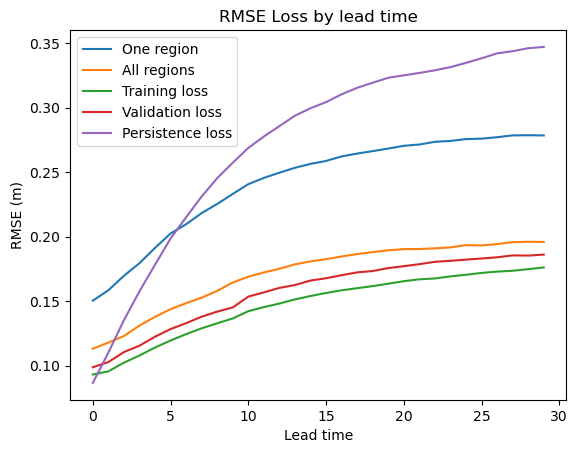

In [29]:
#This loads the .npy files with the losses and plots them
plt.plot(std_ssh*np.sqrt(test_loss),label="One region")
plt.plot(std_ssh*np.sqrt(test_loss_all_regions), label="All regions")
plt.plot(std_ssh*np.sqrt(np.mean(np.load(lossdir+experiment_name+'validationloss.npy'),axis=0)),label="Validation loss")
plt.plot(std_ssh*np.sqrt(np.mean(np.load(lossdir+experiment_name+"trainloss.npy"),axis=0)),label="Train loss")
persistenceloss=np.load("Persistenceloss.npy")
plt.plot((persistenceloss),label="Persistence loss")
plt.legend()
plt.ylabel("RMSE (m)")
plt.xlabel("Lead time")
plt.title("RMSE Loss by lead time")

In [ ]:
#This plots the test loss over the course of the year
import datetime
xs=np.arange(1,335,5)
dates=[]
for x in xs:
    dates.append(datetime.date(2017,1,1)+datetime.timedelta(days=int(x)))
plt.figure(figsize=(10,10))
plt.plot(dates,np.mean(np.stack(test_loss),axis=1))
plt.title("Test error over the course of the year")

In [ ]:
#This creates plots of the test predictions with different lea times
import datetime
predfutshape=futurepredictions.shape
pred11030=futurepredictions.reshape((predfutshape[0]*predfutshape[1],)+predfutshape[2:])
del1=1-1 #lead time of the first axis
del2=10-1
del3=30-1
pred1=pred11030[(del3-del1):,del1]
pred10=pred11030[(del3-del2):,del2]
pred30=pred11030[(del3-del3):,del3]
interpday=15 #the day that we're using for the "ground truth"
statsconvlstm = (0.0761, 0.176, 290.4, 3.914)

start_date=datetime.date(2016,12,17)+datetime.timedelta(days=n_t)+datetime.timedelta(days=del3)
interpolation_day=datetime.date(2016,12,17)+datetime.timedelta(days=interpday)
predinterp=interpprediction[(start_date-interpolation_day).days:,interpday]*statsconvlstm[1]+statsconvlstm[0]

In [ ]:
#This aligns the different days we're comparing 
import datetime
del1=1-1 #lead time of the first axis
del2=10-1
del3=30-1
interpday=15 #the day that we're using for the "ground truth"
statsconvlstm = (0.0761, 0.176, 290.4, 3.914)
n_t=30
start_date=datetime.date(2016,12,17)+datetime.timedelta(days=n_t)+datetime.timedelta(days=del3)
interpolation_day=datetime.date(2016,12,17)+datetime.timedelta(days=interpday)
(start_date-interpolation_day).days

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy


tmax=30 #days per sample
n=128 #pixels per region
L_x = 960e3 # size of domain
L_y = 960e3  # size of domain



savedir='figures/day1day10day30/' #Wherever you want to save the photos to

    
index=0

for day in range(0,335):
    #make the axes and the colorbar
    fig, axs = plt.subplot_mosaic([['ax1', 'ax1','ax2','ax2'],
     ['ax1', 'ax1','ax2','ax2'],['ax3', 'ax3','ax4','ax4'],
     ['ax3', 'ax3','ax4','ax4'],['colorbar', 'colorbar','colorbar','colorbar'],['BLANK', 'BLANK', 'BLANK','BLANK'],],empty_sentinel="BLANK",figsize=(12,18))
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=axs['colorbar'], orientation='horizontal', label='SSH')

    #plot predictions
    axs['ax1'].imshow(np.squeeze(pred1[day])*gs_std_ssh+gs_mean_ssh,norm=norm,cmap=cmap)
    axs['ax1'].set_title("1 day of lead time")
    axs['ax2'].imshow(np.squeeze(pred10[day])*gs_std_ssh+gs_mean_ssh,norm=norm,cmap=cmap)
    axs['ax2'].set_title("10 days of lead time")
    axs['ax3'].imshow(np.squeeze(pred30[day])*gs_std_ssh+gs_mean_ssh,norm=norm,cmap=cmap)
    axs['ax3'].set_title("30 days of lead time")
    axs['ax4'].imshow(np.squeeze(predinterp[day]),norm=norm,cmap=cmap)
    axs['ax4'].set_title("Interpolation")


    #figure and axis titles
    fig.suptitle(f'Prediction for {start_date+datetime.timedelta(days=day)} with different lead times', fontsize=16)


    #save the figure to the save directory
    plt.savefig(savedir+(str(index).zfill(3))+'.jpg')
    index+=1